# TS Clustering Project

William Gilmore

In [16]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings 
import glob

#SciKit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Warnings
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr


## Functions

Compile Function

In [17]:
#Author: Paul
#compiles all voyages

#I've changed all instances of "sail to ds" and changed ddir to be a relative file path -will
def Compile_Datasets(fn_list_in):


    # fn_list_in: list of strings with the file names, or filename(string), or "all"
    # returns: compiled list
    fn_list = []
    
    ddir = "../saildrone_data"
    
    # Make sure the fn_list_in is formatted correctly
    if(fn_list_in == "all"):
        
        fn_list = glob.glob(ddir+ '/*.nc')
    elif(type(fn_list_in) == 'list' and type(fn_list_in[0]) == 'string'):
        fn_list = fn_list_in
    elif(type(fn_list_in) == 'string'):
        fn_list[0] = fn_list_in
    else: 
        raise Exception("first argument to 'Compile_Data_Set_And_Graph' function must be; a list of file names, a file name, or \"all\"")
        
    print()
    
    # open the first dataset
    sail = xr.open_dataset(fn_list[0])
    
    sail = sail.drop_vars("trajectory", errors='ignore')
    
    # give the first dataset a relative ID so all datasets can be differentiated
    sail["relativeID"] = 0
    # make lists for certain variables that remain constant for each dataset. these are used later in the last two cells
    yearList = [sail["time"][0].dt.year]
    durationList = [sail["time"][len(sail["time"]) - 1] - sail["time"][0]]
    # take the actual cruise ID from the dataset attributes and put it in a new list
    try:
        realID = [int(sail.attrs["id"])]
    except:
        realID = [fn_list[0]]
    sail["realID"] = realID[0]
    # add the duration back to the dataset
    sail["duration"] = durationList[0]

    # repeat previous steps for other datasets that need to be combined.

    if len(fn_list) > 1:
        for i in range(1, len(fn_list)):
            temp = xr.open_dataset(fn_list[i])
            temp = temp.drop_vars("trajectory", errors='ignore')
            temp["relativeID"] = i
            yearList.append(temp["time"][0].dt.year)
            
            try:
                realID.append(int(temp.attrs["id"]))
            except:
                realID.append(fn_list[i])
                
            tempDuration = temp["time"][len(temp["time"]) - 1] - temp["time"][0]
            temp["duration"] = tempDuration
            durationList.append(tempDuration)
            temp["realID"] = realID[i]
            sail = xr.concat([sail, temp], dim="time")
            temp.close()

    # reformat dates
    sail['date'] = mdates.date2num(sail['time'].dt.date)

    # ask what variable should be plotted
    return(sail)

## West Coast Selection Function

In [18]:
#Author: William Gilmore
#Isolates data on the westcoast
def westcoast(upperLat, lowerLat):
    
    #upperLat: Upper acceptable latitude
    #lowerLat: Lower acceptable latitude
    # -function will discard all data not between upperLat and lowerLat
    
    # Runs Pauls function to gather all saildrone data into 1 dataset
    ds = Compile_Datasets("all")
    
    #Removes Data outside of Westcoast
    ds = ds.where((ds.lon > -130) & (ds.lon < -115) & (ds.lat > 27) & (ds.lat < 52))
    
    #Removes data that is not within 300 km of shore
    ds = ds.where(ds.dist_land <= 300)
    
    #Removes SF bay data
    ds = ds.where(~(((ds.lon > -122.5938) & (ds.lat > 37.72783)) & ((ds.lon < -122.2506620424831) & (ds.lat < 38.094658646550556))) | ~(((ds.lon > -122.38678630116495) & (ds.lat > 37.430464705762226)) & ((ds.lon < -121.99799777841487) & (ds.lat < 37.81408437558721))))
    
    #Removes Data not between upperLat and lowerLat
    ds = ds.where((ds.lat > lowerLat) & (ds.lat < upperLat))
     

    return(ds)

## Access and Filter Data

Function Calls

In [19]:
#Gather dataset
ds = westcoast(50, 20)

## Kmeans

In [20]:
#Discards all data with salinity less then or equal to 30
#30
ds['SAL_CTD_MEAN']=ds.SAL_CTD_MEAN.where(ds.SAL_CTD_MEAN>=30, np.nan)

#Converts dataset to dataframe only containing tempreature salinity values and location
# We need the location to later plot the clusters onto a map, ignore for now
df = ds[['TEMP_CTD_MEAN', 'SAL_CTD_MEAN', 'lat', 'lon']].to_dataframe()

#Removes all rows with NaN in one of the columns
df = df.dropna()

#Removes unwanted column
df = df.drop('ob', axis = 1)

#Removes location data
df_no_location = df.drop(['lat', 'lon'], axis = 1)

#Returns contents of dataframe as a list which can be input to pipeline
Km_input = df_no_location.values

In [34]:
#Scales data so its weighted equally
scaler =  MinMaxScaler()
scaled_features = scaler.fit_transform(Km_input)

In [35]:
# create kmeans object
kmeans = KMeans(init="random",
                n_clusters=6,
                n_init=10,
                max_iter=300,
                random_state=42)

# fit kmeans object to data
kmeans.fit(scaled_features)

#assigns each point to a cluster 
labels = kmeans.labels_

#Adds groups labels back to the original dataframe
df['labels'] = labels

In [36]:
#Reverse Scaling
#Changes the centroids from being scaled to being the real (temp, sal) data

inverted_scaled_centroids = scaler.inverse_transform(kmeans.cluster_centers_)

## Scaled Graph

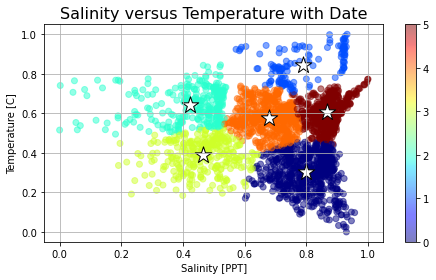

In [37]:
fig = plt.figure(figsize=(7.6,4)) 

#plots data points
sc = plt.scatter(x = scaled_features[:, 1], y = scaled_features[:, 0], c = labels, cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc)

#plots Centroids
plt.scatter(
    kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0],
    s=300, marker='*',
    c='white', edgecolor='black',
    label='centroids'
)

#window dressing
plt.title('Salinity versus Temperature with Date', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
plt.xticks()
plt.grid()



plt.show()

## Normal Graph

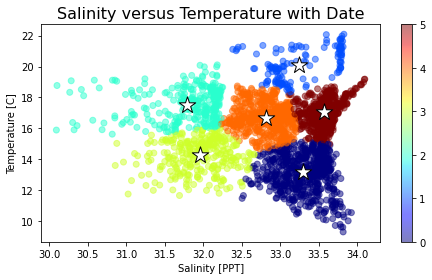

In [38]:
fig = plt.figure(figsize=(7.6,4)) 


#plots data points
sc = plt.scatter(x = Km_input[:, 1], y = Km_input[:, 0], c = labels, cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc)

#plots Centroids
plt.scatter(
    inverted_scaled_centroids[:, 1], inverted_scaled_centroids[:, 0],
   s=300, marker='*',
    c='white', edgecolor='black',
    label='centroids'
)

#window dressing
plt.title('Salinity versus Temperature with Date', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
#plt.grid()



plt.show()

## Elbow Method

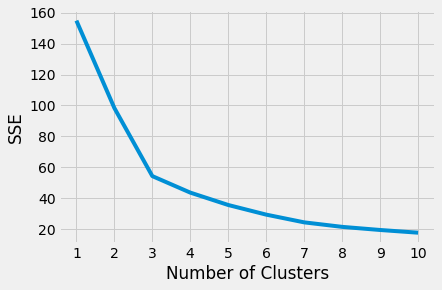

In [39]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    

    
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Elbow appears to be at 3

## Silhouette Coefficiente

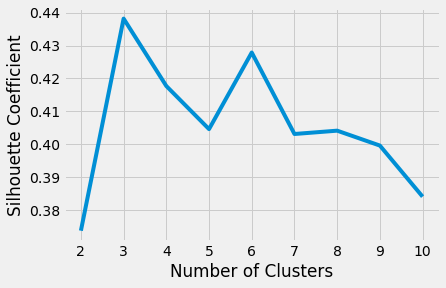

In [40]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### 3 Clusters has the maximum score but something interesting is happening at 6 clusters so that will be investigated as well

#### More advanced methods of optimal cluster analysis rely on ground truth labels which we dont currently have for this dataset.

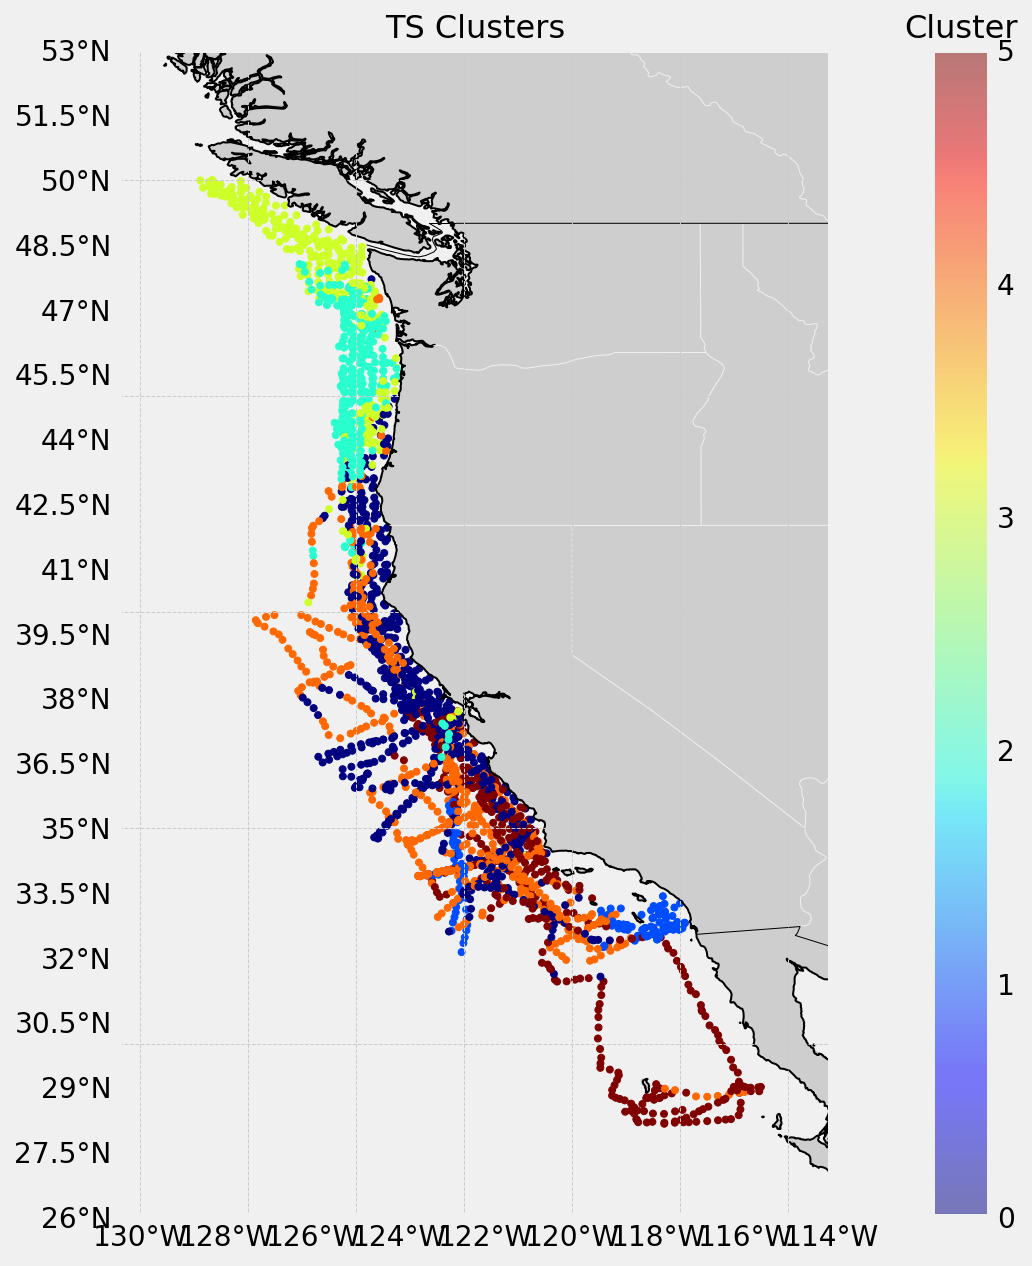

In [41]:

#define latitude and longitude boundaries
latr = [27, 52] 
lonr = [-115, -130] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 144) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

clb = fig.colorbar(sc)
clb.ax.set_title('Cluster', fontdict = {'fontsize' : 16})
                 
# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = df['lon'], y = df['lat'], s = 12, c = df['labels'], cmap='jet')
#plt.plot(ds['lon'], ds['lat'], ls = ':', c = 'navy', alpha = 0.4)
#clb = fig.colorbar(sc, ticks=np.linspace(min(ds['date']), max(ds['date']), 11))

#clb.set_ticklabels(ds['time'].dt.date[default_x_ticks].values)
plt.title('TS Clusters', fontdict = {'fontsize' : 16})
plt.show()

In [42]:
#Plot Cruises 1 at a time
#plot just one month
#plot mean cluster location
#Plot point inception to 40 latitude --Done

## Point Conception to 40°

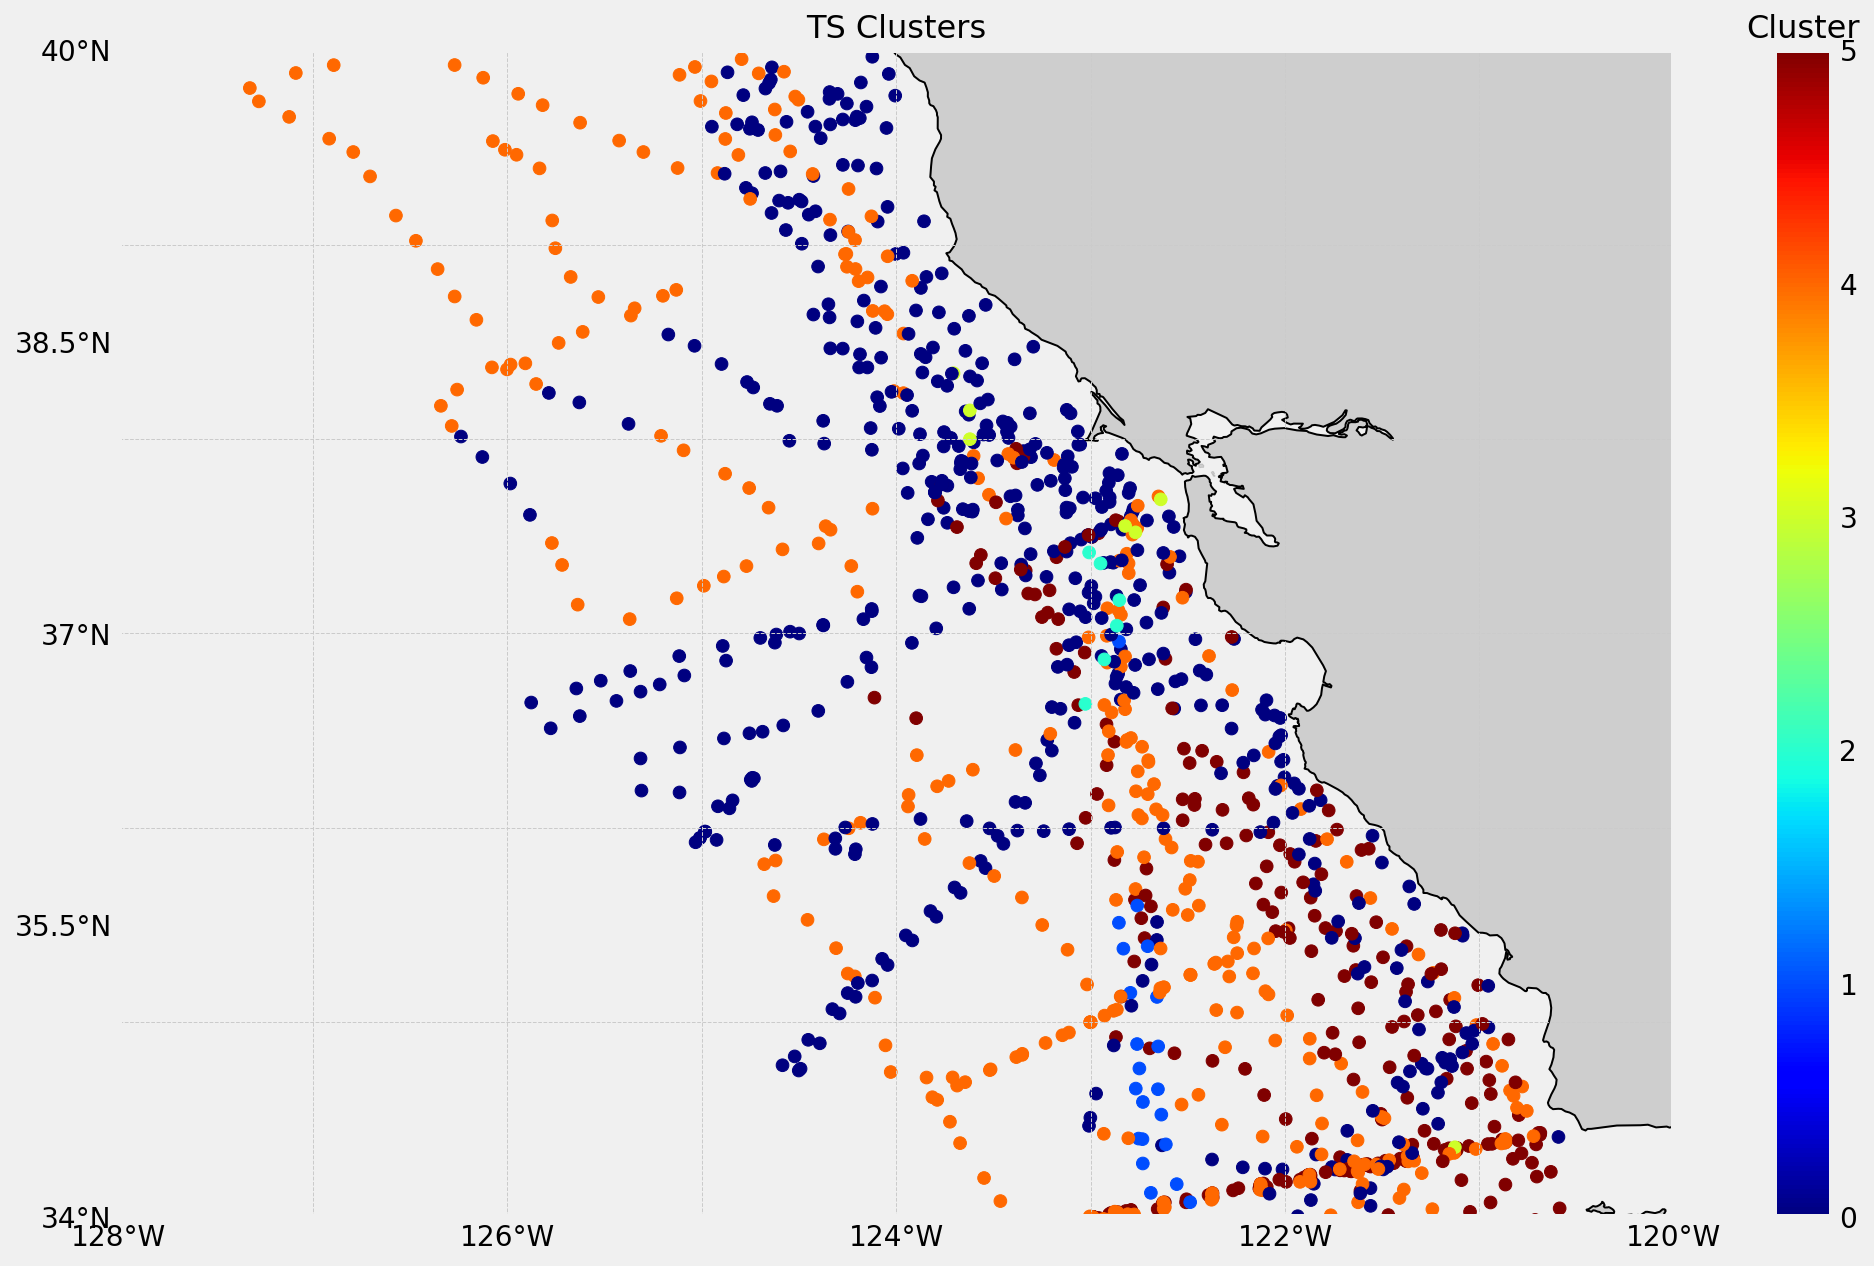

In [47]:
#create list of ticks for the x axis
#default_x_ticks = range(0,len(ds['time']),divmod(len(ds['time']), 10)[0]) #selects out 10 evenly spaced dates from the data

#define latitude and longitude boundaries
latr = [34, 40] 
lonr = [-120, -128] 

# Select a region of our data, giving it a margin

region = np.array([[latr[0],latr[1]],[lonr[0],lonr[1]]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 144) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

clb = fig.colorbar(sc)
clb.ax.set_title('Cluster', fontdict = {'fontsize' : 16})
                 
# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = df['lon'], y = df['lat'], s = 40, c = df['labels'], cmap='jet')
#plt.plot(ds['lon'], ds['lat'], ls = ':', c = 'navy', alpha = 0.4)
#clb = fig.colorbar(sc, ticks=np.linspace(min(ds['date']), max(ds['date']), 11))

#clb.set_ticklabels(ds['time'].dt.date[default_x_ticks].values)
plt.title('TS Clusters', fontdict = {'fontsize' : 16})
plt.show()

## 1 month

In [ ]:
#create list of ticks for the x axis
#default_x_ticks = range(0,len(ds['time']),divmod(len(ds['time']), 10)[0]) #selects out 10 evenly spaced dates from the data

#define latitude and longitude boundaries
latr = [27, 52] 
lonr = [-115, -130] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 144) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

clb = fig.colorbar(sc)
clb.ax.set_title('Cluster', fontdict = {'fontsize' : 16})
                 
# Plot track data, color by temperature
loc = mdates.AutoDateLocator()
sc = plt.scatter(x = df['lon'], y = df['lat'], s = 12, c = df['labels'], cmap='jet')
#plt.plot(ds['lon'], ds['lat'], ls = ':', c = 'navy', alpha = 0.4)
#clb = fig.colorbar(sc, ticks=np.linspace(min(ds['date']), max(ds['date']), 11))

#clb.set_ticklabels(ds['time'].dt.date[default_x_ticks].values)
plt.title('TS Clusters', fontdict = {'fontsize' : 16})
plt.show()